<a href="https://colab.research.google.com/github/packetech/baracuda/blob/master/capstoneNLP_1_2_3_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1>**Capstone Project NLP**</H1>
<b>Automatic Incident Management Ticket Sorting


<h2>03-NLP Project Notes 3</h2>


##**( 1 ) Fine-tuning the model​:** 

##**a. Reiterate the modelling process keeping in mind the areas of improvement**

##**b. Highlight and provide commentary on the steps taken to arrive at the improved model**
 
Please Note: We are going to try to simultaneously perform a and b. And we are going to number them as we proceed.
Also keep in mind that in our milestone-2 our model had 45% performance 
###**Please Note: after some data handling techniques, model improvement via some hyper-parameter adjustments and several iterations; we archieved a performance of 97%**

In [2]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


###**We begin from here onward to enumerate what was done to improve on our model performance**

###**1. Tensorflow version 2.0.0 is installed, and because keras will not work with this out of the box, we have to use tensorflow keras libraries**

######**Exploratory Data Analysis**

Read the DataSet file "input_data.xlsx". Explore the data and get some insights about the data

In [ ]:
#!pip uninstall tensorflow

In [ ]:
#!pip install tensorflow==2.0.0

In [3]:
# Load required libraries

import pandas as pd
import numpy as np
from numpy import array
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

import re

from pickle import dump, load

import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
set(stopwords.words('english'))
nltk.download('punkt')
nltk.download('wordnet')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
#Set project path 
project_path = "/content/drive/My Drive/AIML/CapstoneProjectNLP/"

In [ ]:
# Read data
capstoneNLP_DF = pd.read_excel(project_path+'input_data.xlsx')

In [ ]:
# Display shape and header

print(capstoneNLP_DF.shape)
capstoneNLP_DF.head()

(8500, 4)


,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [ ]:
# Descriptive statistics gives us a lot more insight, just like knowing that 2,948 Callers generated these 8,491 tickets
capstoneNLP_DF.describe().T

,count,unique,top,freq
Short description,8492,7481,password reset,38
Description,8499,7817,the,56
Caller,8500,2950,bpctwhsn kzqsbmtp,810
Assignment group,8500,74,GRP_0,3976


######**Concatenate necessary fields and drop unnecessary ones**

Not all the source text is important, so we need to concatenate the useful ones and drop the un-necessary ones.

In [ ]:
# Combine similar fields and call it 'Desc'
capstoneNLP_DF['Desc'] = capstoneNLP_DF['Short description'] + capstoneNLP_DF['Description']

# Dropping unnecessary fields
capstoneNLP_DF = capstoneNLP_DF.drop(['Short description','Description','Caller'], 1)

# Renaming the "Assignment group" for ease of usage
capstoneNLP_DF = capstoneNLP_DF.rename(columns = {"Assignment group": "Grps"})

capstoneNLP_DF.head()

,Grps,Desc
0,GRP_0,login issue-verified user details.(employee# &...
1,GRP_0,outlook\r\n\r\nreceived from: hmjdrvpb.komuayw...
2,GRP_0,cant log in to vpn\r\n\r\nreceived from: eylqg...
3,GRP_0,unable to access hr_tool pageunable to access ...
4,GRP_0,skype error skype error


###**2. We reduced our classes by filtering out to what we call 'GRP_Others' those classes with very few samples (this is the help us when we are taking care of class imbalance)**

In [ ]:
#We filter out classes with 1 - 6 samples
capstoneNLP_DF_LTS = capstoneNLP_DF[capstoneNLP_DF['Grps'].map(capstoneNLP_DF['Grps'].value_counts()) < 7]

In [ ]:
groupy2 = capstoneNLP_DF_LTS.groupby('Grps').size().sort_values(ascending=False)
groupy2

Grps
GRP_59    6
GRP_46    6
GRP_49    6
GRP_43    5
GRP_66    4
GRP_32    4
GRP_68    3
GRP_63    3
GRP_58    3
GRP_56    3
GRP_38    3
GRP_72    2
GRP_57    2
GRP_54    2
GRP_69    2
GRP_71    2
GRP_67    1
GRP_64    1
GRP_61    1
GRP_70    1
GRP_35    1
GRP_73    1
dtype: int64

In [ ]:
# Replacing the groups that are now seen in groupy2 anyhwere they are found in the main dataset (capstoneNLP_DF) calling them GRP_OTHERS

capstoneNLP_DF_prep = capstoneNLP_DF.replace({'GRP_59':'GRP_OTHERS','GRP_46':'GRP_OTHERS','GRP_49':'GRP_OTHERS','GRP_43':'GRP_OTHERS','GRP_66':'GRP_OTHERS','GRP_32':'GRP_OTHERS','GRP_68':'GRP_OTHERS','GRP_63':'GRP_OTHERS','GRP_58':'GRP_OTHERS','GRP_56':'GRP_OTHERS','GRP_38':'GRP_OTHERS','GRP_72':'GRP_OTHERS','GRP_57':'GRP_OTHERS','GRP_54':'GRP_OTHERS','GRP_69':'GRP_OTHERS','GRP_71':'GRP_OTHERS','GRP_67':'GRP_OTHERS','GRP_64':'GRP_OTHERS','GRP_61':'GRP_OTHERS','GRP_70':'GRP_OTHERS','GRP_35':'GRP_OTHERS','GRP_73':'GRP_OTHERS'})

# 'GRP_51':'GRP_OTHERS','GRP_55':'GRP_OTHERS','GRP_52':'GRP_OTHERS','GRP_53':'GRP_OTHERS','GRP_65':'GRP_OTHERS','GRP_50':'GRP_OTHERS','GRP_44':'GRP_OTHERS','GRP_36':'GRP_OTHERS',

In [ ]:
capstoneNLP_DF_prep.tail()

,Grps,Desc
8495,GRP_29,emails not coming in from zz mail\r\n\r\nrecei...
8496,GRP_0,telephony_software issuetelephony_software issue
8497,GRP_0,vip2: windows password reset for tifpdchb pedx...
8498,GRP_62,machine nÃ£o estÃ¡ funcionandoi am unable to a...
8499,GRP_OTHERS,an mehreren pc`s lassen sich verschiedene prgr...


In [ ]:
# check and remove NAN
print(capstoneNLP_DF_prep.isnull().any(axis = 0))

Grps    False
Desc     True
dtype: bool


In [ ]:
capstoneNLP_DF_prep = capstoneNLP_DF_prep.dropna()
print(capstoneNLP_DF_prep.isnull().any(axis = 0))

Grps    False
Desc    False
dtype: bool


In [ ]:
# Converting categrical labels to numerical format and call them 'Target'
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(capstoneNLP_DF_prep['Grps'])
capstoneNLP_DF_prep['Target'] = le.transform(capstoneNLP_DF_prep['Grps'])
capstoneNLP_DF_prep.tail()

,Grps,Desc,Target
8495,GRP_29,emails not coming in from zz mail\r\n\r\nrecei...,22
8496,GRP_0,telephony_software issuetelephony_software issue,0
8497,GRP_0,vip2: windows password reset for tifpdchb pedx...,0
8498,GRP_62,machine nÃ£o estÃ¡ funcionandoi am unable to a...,47
8499,GRP_OTHERS,an mehreren pc`s lassen sich verschiedene prgr...,52


###**3. Performing text pre-processing (by text lowering, noise/stopwards removal and normalization by stemming)**

In [ ]:
# text lower casing
capstoneNLP_DF_prep['Desc']=[word.lower() for word in capstoneNLP_DF_prep['Desc']]

In [ ]:
# Noise/ stopwords removal and stemming(which is normalization)
stem_word =[]
snow = nltk.stem.SnowballStemmer('english')


for sentence in capstoneNLP_DF_prep['Desc']:
  # remove noise
  
  sentence = re.sub(r'https?:\/\/.*[\r\n]*', '', sentence, flags=re.MULTILINE)
  sentence = re.sub(r'<.*?>','', sentence)
  sentence = re.sub(r'\<a href', ' ', sentence)
  sentence = re.sub(r'&amp;', '', sentence)
  sentence = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', sentence)
  sentence = re.sub(r'<br />', ' ', sentence)
  sentence = re.sub(r'\'', ' ', sentence)
    
  words = [snow.stem(word) for word in sentence.split() if word not in stopwords.words('english')]   # Stemming and removing stopwords
  stem_word.append(words)
    
capstoneNLP_DF_prep['Desc'] = stem_word    

In [ ]:
#  Change short forms into expanded text (a form of normalization)

contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
# further Cleaning text and noise removal
def clean_text(text, remove_stopwords=True):

  # Convert words to lower case
  #text = text.lower()
  if True:
    text = text.split()
    new_text = []
    for word in text:
      if word in contractions:
        new_text.append(contractions[word])
      else:
        new_text.append(word)
      text = " ".join(new_text)
      text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
      text = re.sub(r'\<a href', ' ', text)
      text = re.sub(r'&amp;', '', text)
      text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
      text = re.sub(r'<br />', ' ', text)
      text = re.sub(r'\'', ' ', text)
      
  return text


In [ ]:
# Clean the texts and check to remove stopwords again

clean_Texts = []
for Text in capstoneNLP_DF_prep.Desc:
  clean_Texts.append(clean_text(str(Text), remove_stopwords=True))
print("Texts are complete.")


Texts are complete.


In [ ]:
# check out the clean text
print(clean_Texts[0])

  login    issu    verifi    user    detail    employe    manag    name    check    user    name    ad    reset    password    advis    user    login    check    caller    confirm    abl    login    issu    resolv  


In [ ]:
groups1 = list()
for i, grp in enumerate(capstoneNLP_DF_prep.Grps):
  groups1.append({'Desc': clean_Texts[i], 'Grps': grp})


In [ ]:
groups2 = list()
for i, tar in enumerate(capstoneNLP_DF_prep.Target):
  groups2.append({'Desc': clean_Texts[i], 'Target': tar})


In [ ]:
# save to file
dump(groups1, open(project_path+'capstoneNLP_dataset.pkl', 'wb'))
dump(groups2, open(project_path+'capstoneNLP_dataset2.pkl', 'wb'))

######**Load again the saved clean text**

In [5]:
#Load groups1
groups1 = load(open(project_path+'capstoneNLP_dataset.pkl', 'rb'))
print('Loaded group1') # %d' % len(groups1))
#print(type(groups1))

Loaded group1


In [6]:
#Load groups2
groups2 = load(open(project_path+'capstoneNLP_dataset2.pkl', 'rb'))
print('Loaded group2') #groups %d' % len(groups2))
#print(type(groups2))

Loaded group2


In [7]:
capstoneNLP_DF = pd.DataFrame(groups1)
capstoneNLP_DF2 = pd.DataFrame(groups2)

In [8]:
# print out the header
capstoneNLP_DF.tail()

,Desc,Grps
8486,email come zz mail receiv avg...,GRP_29
8487,telephoni softwar issuetelephoni so...,GRP_0
8488,vip2 window password reset tifpd...,GRP_0
8489,machin nã£o estã¡ funcionandoi u...,GRP_62
8490,mehreren pc`s lassen sich versch...,GRP_OTHERS


In [9]:
capstoneNLP_DF2.tail()

,Desc,Target
8486,email come zz mail receiv avg...,22
8487,telephoni softwar issuetelephoni so...,0
8488,vip2 window password reset tifpd...,0
8489,machin nã£o estã¡ funcionandoi u...,47
8490,mehreren pc`s lassen sich versch...,52


In [10]:
# Merge both datasets
capstoneNLP_DF_prep = pd.merge(capstoneNLP_DF,
                           capstoneNLP_DF2,
                           on='Desc', 
                           how='left') 

In [11]:
# drop duplicates, and reset index
capstoneNLP_DF_prep.drop_duplicates(subset="Desc", inplace=True)
capstoneNLP_DF_prep.reset_index(drop=True, inplace=True)
capstoneNLP_DF_prep

,Desc,Grps,Target
0,login issu verifi user detail ...,GRP_0,0
1,outlook receiv hmjdrvpb komuaywn ...,GRP_0,0
2,cant log vpn receiv eylqgodm ...,GRP_0,0
3,unabl access hr tool pageun a...,GRP_0,0
4,skype error skype error,GRP_0,0
...,...,...,...
7773,email come zz mail receiv avg...,GRP_29,22
7774,telephoni softwar issuetelephoni so...,GRP_0,0
7775,vip2 window password reset tifpd...,GRP_0,0
7776,machin nã£o estã¡ funcionandoi u...,GRP_62,47


In [12]:
# Length of each description
capstoneNLP_DF_prep['length'] = capstoneNLP_DF_prep['Desc'].apply(lambda x: len(x.split(" ")))
capstoneNLP_DF_prep.head()

,Desc,Grps,Target,length
0,login issu verifi user detail ...,GRP_0,0,97
1,outlook receiv hmjdrvpb komuaywn ...,GRP_0,0,81
2,cant log vpn receiv eylqgodm ...,GRP_0,0,53
3,unabl access hr tool pageun a...,GRP_0,0,37
4,skype error skype error,GRP_0,0,17


In [13]:
capstoneNLP_DF_prep["length"].mean()

122.83710465415274

###**4. Adjusting the length of sentences(the maxlen hyper-parameter), keeping it low**

In [14]:
max_features = 7000
maxlen = 30 # used the length mean (122) but the model was so poor, we have tried 53, 45 and now 30: the model is better able to work with 
            # descriptions that are shorter.
embedding_size = 200

In [15]:
#Apply Tokenizer and get indices for words
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(capstoneNLP_DF_prep['Desc']))
X = tokenizer.texts_to_sequences(capstoneNLP_DF_prep['Desc'])
print("Number of Samples:", len(X))
print(X[0])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(capstoneNLP_DF_prep['Target'])
print("Number of Labels: ", len(y))
print(y[0])

Number of Samples: 7778
[46, 20, 230, 18, 169, 220, 48, 54, 82, 18, 54, 251, 23, 12, 300, 18, 46, 82, 608, 244, 79, 46, 20, 207]
Number of Labels:  7778
0


In [16]:
#Vocabulary size
num_words = len(tokenizer.word_index) + 1
vocab_size = num_words
print(num_words)

23676


In [17]:
#Get Glove Word Embeddings
EMBEDDING_FILE = project_path+'glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [18]:
len(embeddings.values())

400000

###**5. Taking care of the imbalance in the classes with RandomOverSampling**
We found that undersampling gave us a model with accuracy in the fifties but oversampling gave over 90%. (I believe that in this case, not reducing the actual sample numbers in the classes with lots of samples gave the model the much needed strength. Just to be clearer, using SMOTE gave us about 70%, while RandomOverSampling did the magic by landing us in the Nineties region in model performance (because we have more trainable parameter).

Just to explain why i prefered to filter 1 - 6 sampled Groups out, because the algorithm here has a parameter k_neighbors that is by default 5 (so any Group with samples less than 6 will hamper this algorithm except we manually adjust this parameter and that will compromise it's efficiency)

In [19]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [20]:
# Dealing with imbalance in the classes

#smote = SMOTE(ratio='minority', random_state=0)
ros = RandomOverSampler(sampling_strategy='auto',random_state=0)
X_sm, y_sm = ros.fit_sample(X, y)
#rus = RandomUnderSampler(ratio='majority', random_state=0)
#X_sm, y_sm = rus.fit_sample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [21]:
zX = np.array(X_sm)
print(zX.shape)

(176437, 30)


In [22]:
zy = np.array(y_sm)
print(zy.shape)

(176437,)


In [23]:
# onehot encoding the label
num_classes = 53
y_sm = to_categorical(y_sm, num_classes)

In [24]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.20, random_state=42)

###**6. Adding Early Stoping callback parameter gave the best number of iterations**

In [25]:
#Initializing Early stopping and Model chekpoint callbacks 
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

###**7. Adding dropout to make the model a bit more complex**

Binary_crossentropy loss was chosen because here we are not dealing with a multi-class classification problem ( i.e. at each iteration or ephoch we do not expect each sample to be classified into more than one class )

In [26]:
#model building

deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128, dropout=0.2)(embedding_layer)
dense_layer_1 = Dense(num_classes, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

epochs = 100


# Let's print the model summary:
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 200)           4735200   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               168448    
_________________________________________________________________
dense (Dense)                (None, 53)                6837      
Total params: 4,910,485
Trainable params: 175,285
Non-trainable params: 4,735,200
_________________________________________________________________
None


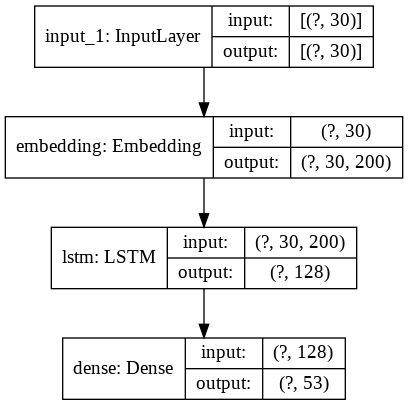

In [27]:
# The following script prints the architecture of our neural network:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

###**8. Increasing the ephochs hyper-parameter with a batch size of 64**

In [28]:
# From the figure above, you can see that the output layer only contains 1 dense layer with 53 neurons. Let's now train our model:

history = model.fit(X_train, y_train, batch_size=64, epochs=epochs, verbose=1, callbacks=early_stopping, validation_split=0.2)

Epoch 1/100
1765/1765 [==============================] - 11s 6ms/step - loss: 0.0764 - acc: 0.2859 - val_loss: 0.0503 - val_acc: 0.5424
Epoch 2/100
1765/1765 [==============================] - 10s 6ms/step - loss: 0.0354 - acc: 0.7048 - val_loss: 0.0214 - val_acc: 0.8310
Epoch 3/100
1765/1765 [==============================] - 10s 6ms/step - loss: 0.0177 - acc: 0.8618 - val_loss: 0.0121 - val_acc: 0.9005
Epoch 4/100
1765/1765 [==============================] - 10s 6ms/step - loss: 0.0114 - acc: 0.9109 - val_loss: 0.0082 - val_acc: 0.9317
Epoch 5/100
1765/1765 [==============================] - 10s 6ms/step - loss: 0.0085 - acc: 0.9318 - val_loss: 0.0066 - val_acc: 0.9412
Epoch 6/100
1765/1765 [==============================] - 10s 6ms/step - loss: 0.0070 - acc: 0.9426 - val_loss: 0.0055 - val_acc: 0.9480
Epoch 7/100
1765/1765 [==============================] - 10s 6ms/step - loss: 0.0059 - acc: 0.9498 - val_loss: 0.0048 - val_acc: 0.9543
Epoch 8/100
1765/1765 [=========================

###**Summary:**
######**The steps taken to improve the model are itemized below**

1. Tensorflow version 2.0.0 is installed, and because keras will not work with this out of the box, we have to use tensorflow keras libraries

2. We reduced our classes by filtering out to what we call 'GRP_Others' those classes with very few samples (this is the help us when we are taking care of class imbalance)


3. Performing text pre-processing (by text lowering, noise/stopwards removal and normalization by stemming)


4. Adjusting the length of sentences(the maxlen hyper-parameter), keeping it low


5. Taking care of the imbalance in the classes with RandomOverSampling

   We found that undersampling gave us a model with accuracy in the fifties but oversampling gave over 90%. ( I believe that in this case not reducing the actual sample numbers in the classes with lots of samples gave the model the much needed strength. Just to be clearer, using SMOTE gave us about 70%, while RandomOverSampling did the magic by landing us in the nineties region in model performance(because we have more trainable parameter).


6. Adding Early Stoping callback parameter gave the best number of iterations


7. Adding dropout to make the model a bit more complex


8. Increasing the ephochs hyper-parameter with a batch size of 64

##**( 2 ) Interpretation and Recommendations**

###**a. Provide interpretations from the model and report the final model evaluation metrics**




######**Model Evaluation and Plots**

In [29]:
# Let's now evaluate our model on the test set:

score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

1103/1103 [==============================] - 3s 3ms/step - loss: 0.0028 - acc: 0.9705
Test Score: 0.00283292168751359
Test Accuracy: 0.9704715609550476


Our model achieves an accuracy of about 97% which is pretty impressive

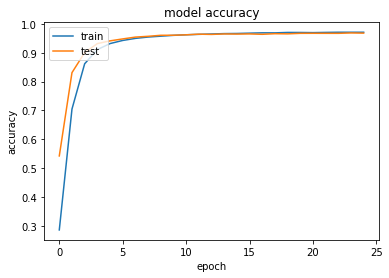

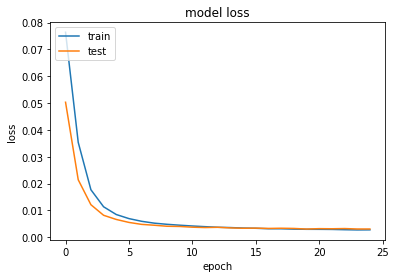

In [30]:
# Finally, we will plot the loss and accuracy values for training and test sets to see what happened to our model

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

######**Observation**

As can be seen the model is not overfitting on the validation set. Therefore, the model should performance well on unseen data, it is a good fit

######**Predict and reporting**

In [31]:
from sklearn.metrics import classification_report,confusion_matrix

Y_pred = model.predict(X_test)
y_pred = np.rint(Y_pred)
y_pred = np.argmax(Y_pred,axis=1)
y_test = np.argmax(y_test,axis=1)
print('  Classification Report:\n',classification_report(y_test,y_pred),'\n')

  Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.74      0.85       687
           1       1.00      1.00      1.00       621
           2       0.98      1.00      0.99       636
           3       1.00      1.00      1.00       661
           4       0.99      0.96      0.97       624
           5       0.99      1.00      1.00       656
           6       0.99      0.98      0.98       633
           7       1.00      1.00      1.00       701
           8       0.99      1.00      1.00       709
           9       1.00      1.00      1.00       672
          10       0.99      1.00      1.00       648
          11       0.96      1.00      0.98       674
          12       0.96      0.99      0.98       665
          13       1.00      0.97      0.98       671
          14       1.00      1.00      1.00       663
          15       1.00      1.00      1.00       645
          16       0.99      1.00      1.00       665
 

######**Observation**
From our classification report: 

1. Filtering Groups that have between 1 - 6 samples into GRP_Others, combined with random oversampling with focus on the minority classes the model could predict on all labels with over 90% in precisions (with some actually at a 100%). And the model accuracy and f1-score of 97% actually agrees to that (i.e. F1-score being the weighed average of our precision and recall)
2. We did filtering between 1 - 15 samples into GRP_Others before now, the model was 96%

It is worth noting that the last group label 52 is the number 53rd class which is GRP_Others "

###**b. Report the recommendations, summarize the project and mention identified next steps**

######**Save model**

In [32]:
# Save the trained weights and model in h5 files
model.save(project_path+'capstoneNLP_ITSM.h5')
model.save_weights(project_path+'capstoneNLP_ITSM_weights.h5')

######**Project Summary:**

######**i- Recommendation**
In a production environment, I would recommend filtering Groups with 1 - 6 samples into 'GRP_Other' over higher filterings or using the whole 74 classes, as we have a balance of predictions on more labels and a good accuracy leaving only a few Groups are to be manually sorted out in 'GRP_Others'.

######**ii- summarizing the project**
In the business domain we were told that L1/L2 resolves about 54% of the incidents but before that they need to do the classification manually and this take them about 26day based on our calculation since they have to review about 30% of the incidents(this actually could be seen to be there accuracy, since there make lots of mis-classifications)

But with the Machine Learning Classification and accuracy of 97%; by proportionality we can say if 30% manually accuracy attents to 30% of the total incidents in the dataset and it took 26days to classify them with so much errors, then our model's 97% accuracy can do a 97% incident classification and this will be in a few minutes with fewer errors.

With the analogy above, out model will allow L1/L3 to concentrate on resolving the incidents rather than classification. 
Furthermore: If they were resolving 54% of the incidents when they were manually classifying 30%, now that the model is classifying 97%; by proportionality they should be resolving about 174.6% of incidents (this is practically not possible though, but theoretically, the point is they should resolve much more than before). And so, “Keep the lights on” to ensure there is no impact on the business operations.

######**iii- Identifying next steps**

The next identified step is to deploy the model, and the options are:

1. As a standalone executable file - recommended for batch mode
2. As an on-prem application exposed as an API (e.g. Flask)
3. As a container based API in Azure or AWS container registry
4. Implemented as an API built on Azure ML or AWS SageMaker


To deploy in a production environment I would do the following using step 3 above:

1. Train this NLP model (with a transformer LSTM Neural Network)
2. Create a full-stack application using python rapper or Flask
3. Containerize using docker and test locally
4. Deploy app on Google Cloud using Kubernetes
5. Create a CI/CD architecture to continually train model on live data


